In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# !! need to insert this path to load h5py without errors!
#  (otherwise Python tries to load the h5py in default site-packages and throws an ImportError)
import sys
sys.path.insert(0, '/work2/08811/aew492/frontera/venv/illustris3.9/lib/python3.9/site-packages')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate
import astropy.units as u
import astropy.cosmology.units as cu
import os
import illustris_python as il

sys.path.insert(0, '/work2/08811/aew492/frontera/small-scale_cross-corrs/code')
from xcorr_cases import HSC_Xcorr
from illustris_sim import TNGSim

#### spectroscopic galaxy densities from lookup table

In [4]:
snapshots = np.arange(35, 80)
redshifts = []
target_ns_ELG = []
target_ns_LRG = []
target_ns_QSO = []
for i, snapshot in enumerate(snapshots):
    Sim = TNGSim('TNG300-3', snapshot=snapshot)
    redshifts.append(Sim.redshift)
    target_ns_ELG.append(Sim.survey_params('DESI', 'ELG').n_Mpc3)
    target_ns_LRG.append(Sim.survey_params('DESI', 'LRG').n_Mpc3)
    target_ns_QSO.append(Sim.survey_params('DESI', 'QSO').n_Mpc3)

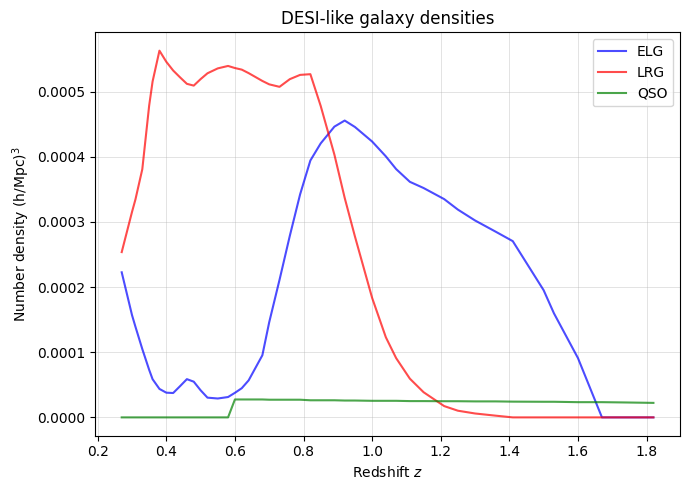

In [5]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(redshifts, target_ns_ELG, c='b', alpha=0.7, label='ELG')
ax.plot(redshifts, target_ns_LRG, c='r', alpha=0.7, label='LRG')
ax.plot(redshifts, target_ns_QSO, c='g', alpha=0.7, label='QSO')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Number density (h/Mpc)$^3$')
ax.set_title('DESI-like galaxy densities')
ax.legend()

In [6]:
# main inputs
snapshotss = [
    np.arange(59, 84), # center at z~0.45
    np.arange(47, 70), # center at z=0.75
    np.arange(40, 62),  # center at z=1.
    np.arange(35, 54)  # center at z=1.25
]

# the photo-z bins
photzbins = np.arange(0, 4)

# galaxy number density
density = 4e-4 * (cu.littleh / u.Mpc)**3

hsc_kwargs = dict(density_type='fixed', density=density, reference_survey='DESI', reference_tracer='ELG')

#### photometric redshift kernels

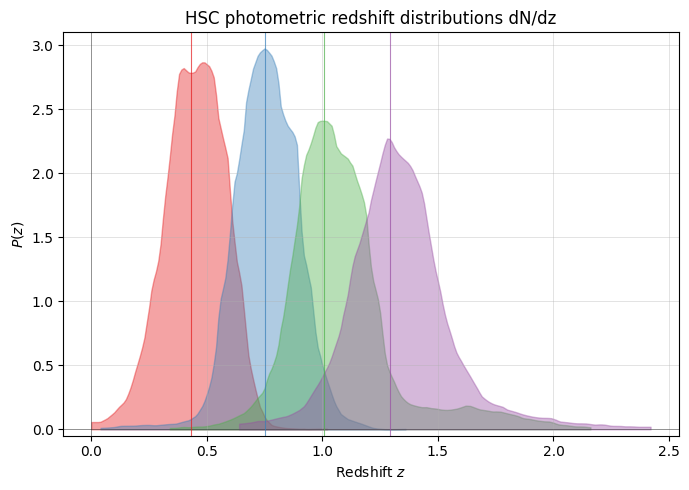

In [12]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
norm = mpl.colors.Normalize(vmin=min(photzbins), vmax=9)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='Set1')
ax.axhline(0, c='k', lw=0.5, alpha=0.5)
ax.axvline(0, c='k', lw=0.5, alpha=0.5)
ax.set_ylim(-.05, 3.1)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'$P(z)$')
ax.set_title(r'HSC photometric redshift distributions dN/dz')
for (snapshots, photzbin) in zip(snapshotss, photzbins):
    # instantiate spherex set for cross-correlation
    X = HSC_Xcorr(snapshots, photzbin, **hsc_kwargs)
    ax.fill_between(X.photzdata['z'], X.photzdata['pz'], color=smap.to_rgba(X.photzbin), alpha=0.4)
    #ax.axvline(min(X.redshifts), c=smap.to_rgba(X.photzbin), alpha=0.7)
    #ax.axvline(max(X.redshifts), c=smap.to_rgba(X.photzbin), alpha=0.7)
    ax.axvline(np.mean(X.redshifts), c=smap.to_rgba(X.photzbin), alpha=0.7, ls='-', lw=0.8)

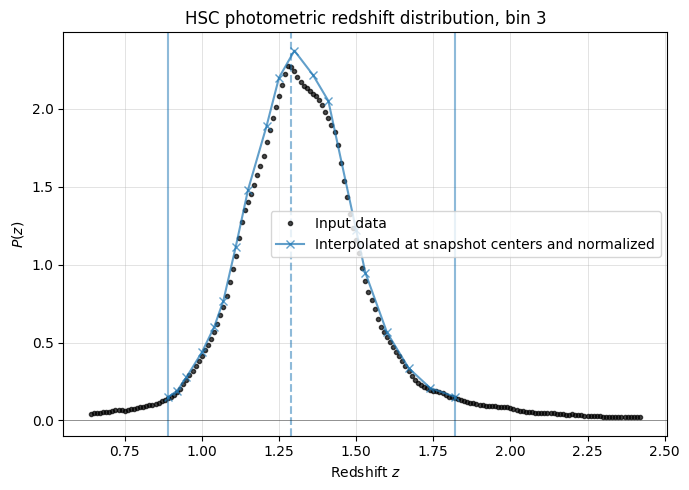

In [15]:
# plot the photometric redshift info, and the interpolated data
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.plot(X.photzdata['z'], X.photzdata['pz'], 'k.', alpha=0.7, label='Input data')
ax.plot(X.redshifts, X.pz, 'x-', alpha=0.7, c='C0', label='Interpolated at snapshot centers and normalized')
ax.grid(alpha=0.5, lw=0.5)
ax.axvline(min(X.redshifts), c='C0', alpha=0.5)
ax.axvline(max(X.redshifts), c='C0', alpha=0.5)
ax.axvline(np.mean(X.redshifts), c='C0', ls='--', alpha=0.5)
ax.axhline(0, c='k', lw=0.5, alpha=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'$P(z)$')
ax.set_title(f'HSC photometric redshift distribution, bin {X.photzbin}')
ax.legend()

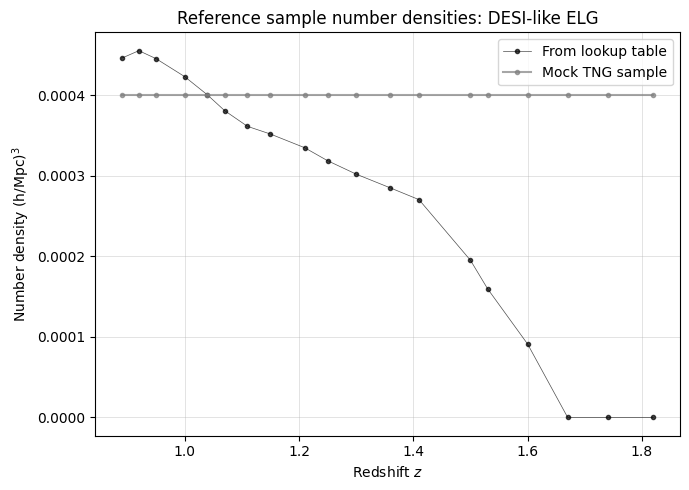

In [16]:
# plot the spectroscopic densities
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
ax.plot(X.redshifts, X.target_ns, 'k.-', lw=0.5, alpha=0.7, label='From lookup table')
ax.plot(X.redshifts, X.ns, '.-', c='grey', alpha=0.7, label='Mock TNG sample')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Number density (h/Mpc)$^3$')
ax.set_title(f'Reference sample number densities: {X.reference_survey}-like {X.reference_tracer}')
ax.legend()

In [78]:
# normalize so that P(z) integrates to 1
area = np.trapz(X.pz, x=X.redshifts)
area

0.9495746242093133

In [79]:
area = np.trapz(X.photzdata['pz'], x=X.photzdata['z'])
area

1.0074706752161686

In [17]:
# construct the spectroscopic galaxies in each snapshot
X.construct_spectroscopic_galaxy_samples()

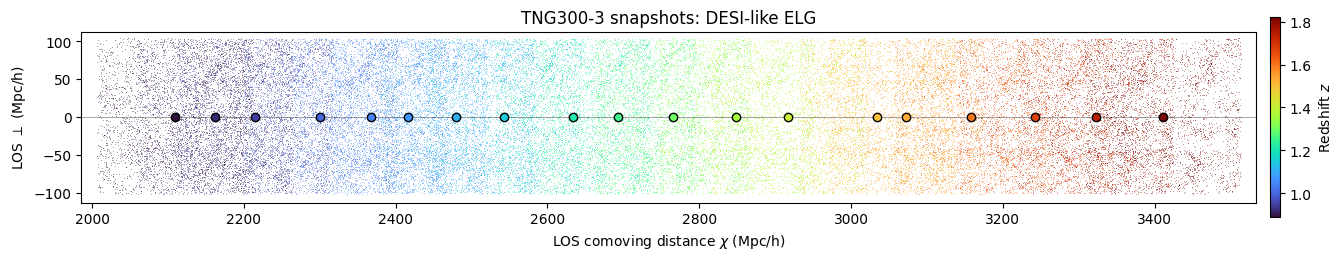

In [18]:
# plot
norm = mpl.colors.Normalize(vmin=min(X.redshifts), vmax=max(X.redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(15,2.6), tight_layout=True)
for i, chi in enumerate(X.chis):
    gal_pos_spec_ = np.copy(X.gal_pos_specs[i])
    gal_pos_spec_[:,2] += chi
    kwargs = dict(c=smap.to_rgba(X.redshifts[i]), ls='None')
    ax.plot(gal_pos_spec_[:,2], gal_pos_spec_[:,0], marker=',', alpha=0.4, **kwargs)
    ax.plot(chi, 0, marker='o', c=smap.to_rgba(X.redshifts[i]), mec='k', zorder=100)
    ax.axvline((chi - X.boxsize/2).value, alpha=0.8, **kwargs)
    ax.axvline((chi + X.boxsize/2).value, alpha=0.8, **kwargs)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.set_aspect('equal')
ax.set_xlim((min(X.chis)-0.6*X.boxsize).value, (max(X.chis)+0.6*X.boxsize).value)
ax.set_xlabel(r'LOS comoving distance $\chi$ (Mpc/h)')
ax.set_ylabel(r'LOS $\perp$ (Mpc/h)')
ax.set_title(f'{X.sim} snapshots: {X.reference_survey}-like {X.reference_tracer}')
fig.colorbar(smap, ax=ax, label='Redshift $z$', pad=0.01)

In [82]:
# compute angular cross-correlation
X.compute_angular_xcorrs()

computing angular xcorrs from pair counts
computing angular xcorrs from linear theory


Text(0.45, 0.95, 'Phot. x spec. cross-correlation, $z=$0.21-0.7, phot-z bin 0')

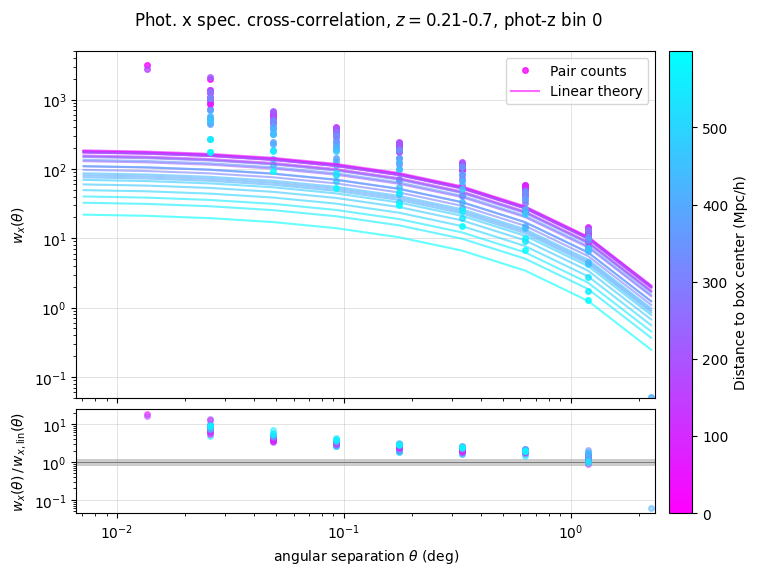

In [83]:
# plot the cross-correlations
norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(X.chis-X.central_chi).value))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig = plt.figure(figsize=(9,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.3], hspace=0.05)

ax0 = fig.add_subplot(gs[0])
for i, w in enumerate(X.wthetax):
    kwargs = dict(c=smap.to_rgba(np.abs(X.chis[i] - X.central_chi).value))
    label = 'Pair counts' if i==len(X.wthetax)//2 else ''
    ax0.plot(X.theta_avg, w, marker='o', ms=4, ls='None', alpha=0.8, label=label, **kwargs)
    label = 'Linear theory' if i==len(X.wthetax)//2 else ''
    ax0.plot(X.theta_avg, X.wthetax_lin[i], alpha=0.6, label=label, **kwargs)
# secax = ax0.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
# secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax0.set_ylim(5e-2,5e3)
ax0.set_ylabel(r'$w_x(\theta)$')
ax0.legend()

ax1 = fig.add_subplot(gs[1])
ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
for i, w in enumerate(X.wthetax):
    ax1.plot(X.theta_avg, w / X.wthetax_lin[i], marker='o', ms=4, alpha=0.5, ls='None',
             c=smap.to_rgba(np.abs(X.chis[i] - X.central_chi).value))
ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
ax1.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
ax1.set_xlabel(r'angular separation $\theta$ (deg)')

for ax in (ax0, ax1):
    ax.loglog()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlim(min(X.theta_avg)-5e-4, max(X.theta_avg)+1e-1)

fig.colorbar(smap, ax=[ax0,ax1], label='Distance to box center (Mpc/h)', pad=0.02)
fig.suptitle(r'Phot. x spec. cross-correlation, $z=$'f'{min(X.redshifts)}-{max(X.redshifts)}, phot-z bin {X.photzbin}',
             x=0.45, y=0.95)

Text(0.45, 0.95, 'Phot. x spec. cross-correlation, $z=$0.21-0.7, phot-z bin 0')

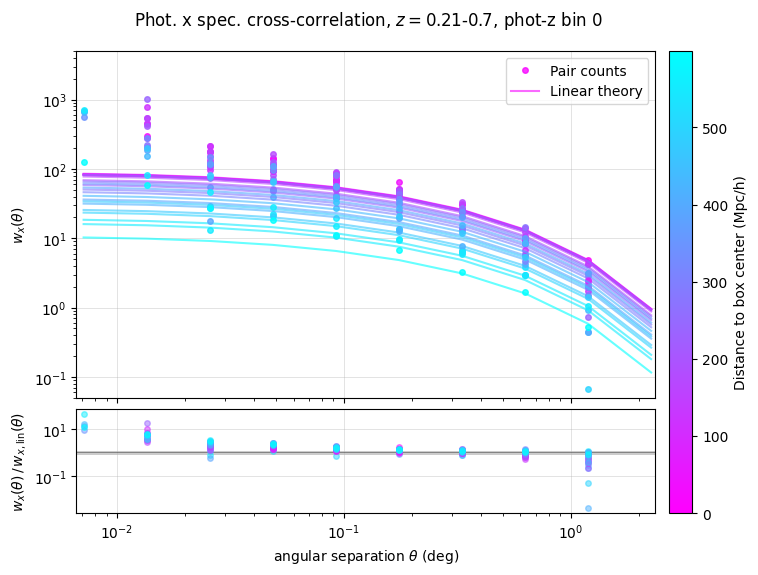

In [41]:
# plot the cross-correlations
norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(X.chis-X.central_chi).value))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig = plt.figure(figsize=(9,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.3], hspace=0.05)

ax0 = fig.add_subplot(gs[0])
for i, w in enumerate(X.wthetax):
    kwargs = dict(c=smap.to_rgba(np.abs(X.chis[i] - X.central_chi).value))
    label = 'Pair counts' if i==len(X.wthetax)//2 else ''
    ax0.plot(X.theta_avg, w, marker='o', ms=4, ls='None', alpha=0.8, label=label, **kwargs)
    label = 'Linear theory' if i==len(X.wthetax)//2 else ''
    ax0.plot(X.theta_avg, X.wthetax_lin[i], alpha=0.6, label=label, **kwargs)
# secax = ax0.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
# secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
ax0.set_ylim(5e-2,5e3)
ax0.set_ylabel(r'$w_x(\theta)$')
ax0.legend()

ax1 = fig.add_subplot(gs[1])
ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
for i, w in enumerate(X.wthetax):
    ax1.plot(X.theta_avg, w / X.wthetax_lin[i], marker='o', ms=4, alpha=0.5, ls='None',
             c=smap.to_rgba(np.abs(X.chis[i] - X.central_chi).value))
ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
ax1.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
ax1.set_xlabel(r'angular separation $\theta$ (deg)')

for ax in (ax0, ax1):
    ax.loglog()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlim(min(X.theta_avg)-5e-4, max(X.theta_avg)+1e-1)

fig.colorbar(smap, ax=[ax0,ax1], label='Distance to box center (Mpc/h)', pad=0.02)
fig.suptitle(r'Phot. x spec. cross-correlation, $z=$'f'{min(X.redshifts)}-{max(X.redshifts)}, phot-z bin {X.photzbin}',
             x=0.45, y=0.95)